# VQC, SVM, and Feature Map

The contents of this notebook are strongly based on the following paper:
https://arxiv.org/pdf/1804.11326.pdf

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.circuit.library import ZZFeatureMap
%matplotlib inline

## VQC

In [17]:
def U(theta, layer, numMeasurements=None):
    rotations, qubits, layers = theta.shape
    if rotations != 2:
        raise Exception("First dimension of theta must be 2!")
    if layer >= layers:
        raise Exception("Layer {} is greater than number of layers!".format(layer))
    
    if numMeasurements is None:
        numMeasurements = qubits
    
    circ = QuantumCircuit(qubits, numMeasurements)
    for q in range(qubits):
        circ.ry(theta[0][q][layer], q)
        circ.rz(theta[1][q][layer], q)
    return circ

def U_ent(qubits, numMeasurements=None):
    if qubits < 2:
        raise Exception("Not enough qubits to create U_ent")
    if numMeasurements is None:
        numMeasurements = qubits
    circ = QuantumCircuit(qubits, numMeasurements)
    
    for i in range(qubits-1):
        circ.cz(i, i+1)
    
    if qubits != 2:
        circ.cz(qubits-1, 0) # TODO Check, this may be qc.cz(0, qubits-1)
    return circ

def buildCircuit(theta, numMeasurements=None):
    rotations, qubits, layers = theta.shape
    if rotations != 2:
        raise Exception("First dimension of theta must be 2!")
    
    if numMeasurements is None:
        numMeasurements = qubits
    circ = QuantumCircuit(qubits, numMeasurements)
    for i in range(layers-1):
        circ += U(theta, i, numMeasurements)
        circ += U_ent(qubits, numMeasurements)
    circ += U(theta, layers-1, numMeasurements)
    
    # Add Measurments
    circ.measure(range(numMeasurements), range(numMeasurements))
    
    return circ

Theta:
[[[-1.04775554 -0.19514304 -0.01302218 -1.17349848]
  [-1.43108236 -0.68555434 -1.07469069  3.44212403]]

 [[ 0.43632055 -1.31026912  1.43067239 -0.60194387]
  [ 0.75825041 -0.74387734 -0.77716401 -0.28201385]]]


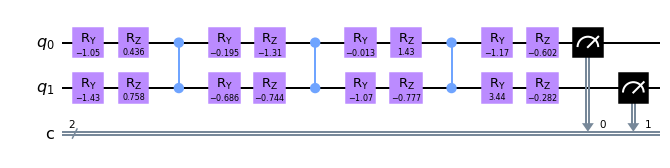

In [18]:
qubits = 2
layers = 4
theta = np.random.randn(2, qubits, layers)
circ = buildCircuit(theta)
print("Theta:")
print(theta)
circ.draw("mpl")

Theta:
[[[ 0.3637929  -0.11648145  1.43189075  2.92724283  0.59729553]
  [ 0.31018402  1.58281556 -0.34851     1.21726939  0.95379802]
  [-1.15356821  0.55544729 -2.41708813 -1.29377649 -1.31353351]]

 [[-0.0483588   0.84386414 -1.81362921  0.01845932  0.5274493 ]
  [-0.45048745 -1.01684049 -0.54162882 -0.22069166  0.76562255]
  [ 0.80711756  1.46075597 -0.0614501   0.51746426  0.56458616]]]


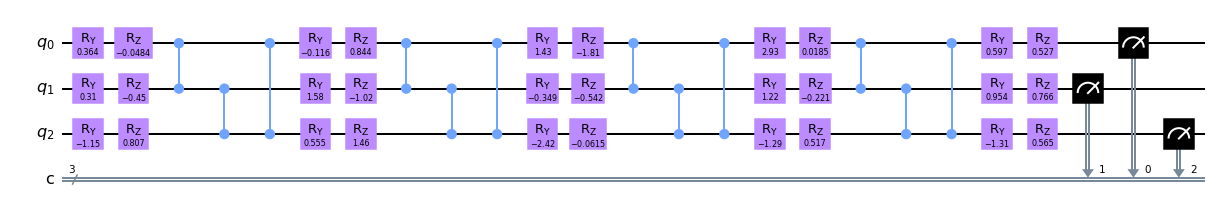

In [19]:
qubits = 3
layers = 5
theta = np.random.randn(2, qubits, layers)
circ = buildCircuit(theta)
print("Theta:")
print(theta)
circ.draw("mpl")